This notebook is made to run on colab.<br>

In [ ]:
# Install required packages to use colab's GPU
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 420 MB of archives.
After this operation, 3,369 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.4.1.50-1+cuda11.6 [420 MB]
53% [1 libcudnn8 277 MB/420 MB 66%]^C


In [ ]:
# Mount google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Note that you should change the path in the next cell according to where you have cloned the repository

In [ ]:
# Current directory path
curr_path = '/content/drive/MyDrive/car-brand-classification'  
%cd {curr_path}

/content/drive/MyDrive/car_brand_detection/Github/car-brand-classification


In [ ]:
!pwd

/content/drive/MyDrive/car_brand_detection/Github/car-brand-classification


In [ ]:
!ls

car_brand_classfication.ipynb  data  LICENSE  models  README.md


In [ ]:
# Import function
import os 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

### In this notebook we are using front view images of 3 different car brands to train a car brand detection model.<br>
The data is scraped from web. There are around 75 images belonging to 3 class. Images are only the front view of the cars.

### To avoid bias due to the dominant color of each car brand, images are turned into grayscale images before feeding them to the model.

In [ ]:
# This function turns the pictures into grayscale format with 3 channels.
def to_grayscale_then_rgb(image):
  image = tf.image.rgb_to_grayscale(image)
  image = tf.image.grayscale_to_rgb(image)
  return image

### Using the ImageDataGenerator, we define the train and validation sets.
This functions allows us to apply augmentation to the training set as it is loaded into memory and train the model on it. This means we don't need to create new images and save them on our disk.

In [ ]:
source = 'data'
train_dir = os.path.join(source, 'train')
validation_dir = os.path.join(source, 'validation')

train_datagen = ImageDataGenerator(rescale=1./255.,
                                   width_shift_range=.2,
                                   height_shift_range=.2,
                                   zoom_range=.2,
                                   horizontal_flip=True,
                                   rotation_range=40,
                                   preprocessing_function=to_grayscale_then_rgb,
                                   shear_range=.2)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(400,400),
                                                    class_mode='categorical',
                                                    batch_size=2)

validation_datagen = ImageDataGenerator(rescale=1./255.)
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(400,400),
                                                              class_mode='categorical',
                                                              batch_size=1)

Found 59 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


### Now let's take a look at the images in the training set

In [ ]:
%cd '/content/drive/MyDrive/car_brand_detection/Github/car-brand-classification/'

/content/drive/MyDrive/car_brand_detection/Github/car-brand-classification


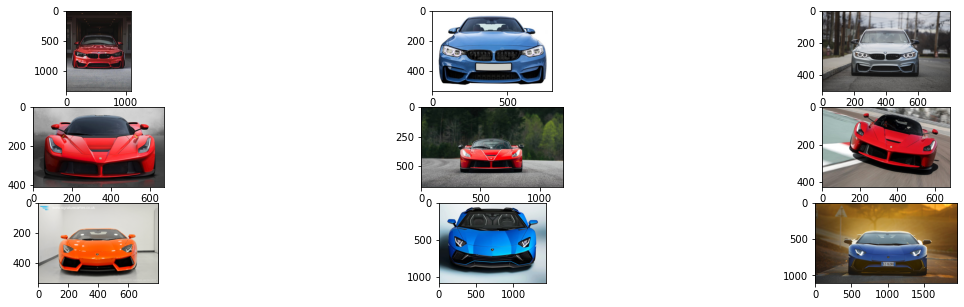

In [ ]:
classes = list(train_generator.class_indices.keys())

fig, axis = plt.subplots(3,3, figsize=(20,5))
for row in range(3):
  curr_dir = os.path.join(train_dir, classes[row]) 
  list_dir = os.listdir(curr_dir)
  for col in range(3):
    image = plt.imread(os.path.join(train_dir, classes[row], list_dir[col+5]))
    axis[row, col].imshow(image)
plt.show()

### Now it's time to load our pre-trained model and set the layers to be not trainable. It is a common act in transfer learning to add one or two dense layer with the relavant output shape and trained the model only for those layers.

#### In this notebook we will use the VGG16 model for transfer learning.

In [ ]:
from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (400,400,3))
for layer in pre_trained_model.layers:
    layer.trainable = False
pre_trained_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                              

### We will add a global average pooling layer and 3 more dense layers to the model to have them trained on the train set.

In [ ]:
from tensorflow.keras.models import Model


x = pre_trained_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(3, activation='softmax')(x)

model = Model(inputs=pre_trained_model.input, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0     

### Now we have to compile the model and have it trained for 50 epochs.

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=0.0002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    verbose=1
)

Epoch 1/50
 2/30 [=>............................] - ETA: 1:25 - loss: 1.7916 - accuracy: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


30/30 [==============================] - 114s 4s/step - loss: 1.2295 - accuracy: 0.2373 - val_loss: 1.1057 - val_accuracy: 0.3333
Epoch 2/50
30/30 [==============================] - 110s 4s/step - loss: 1.0644 - accuracy: 0.4237 - val_loss: 1.0683 - val_accuracy: 0.2667
Epoch 3/50
30/30 [==============================] - 112s 4s/step - loss: 1.0508 - accuracy: 0.4915 - val_loss: 1.0866 - val_accuracy: 0.3333
Epoch 4/50
30/30 [==============================] - 113s 4s/step - loss: 1.0106 - accuracy: 0.4237 - val_loss: 0.8685 - val_accuracy: 0.6667
Epoch 5/50
30/30 [==============================] - 111s 4s/step - loss: 0.9277 - accuracy: 0.5424 - val_loss: 0.8030 - val_accuracy: 0.7333
Epoch 6/50
30/30 [==============================] - 112s 4s/step - loss: 0.8421 - accuracy: 0.7119 - val_loss: 0.7317 - val_accuracy: 0.7333
Epoch 7/50
30/30 [==============================] - 112s 4s/step - loss: 0.7901 - accuracy: 0.6271 - val_loss: 0.6923 - val_accuracy: 0.7333
Epoch 8/50
30/30 [======

### save the model 

In [ ]:
path = 'models/VGG16'
if not os.path.exists(path):
  !mkdir -p {path}

In [ ]:
model.save(os.path.join(path, "car_classification_vgg16_50ep.h5"))

### Plot the learning curve

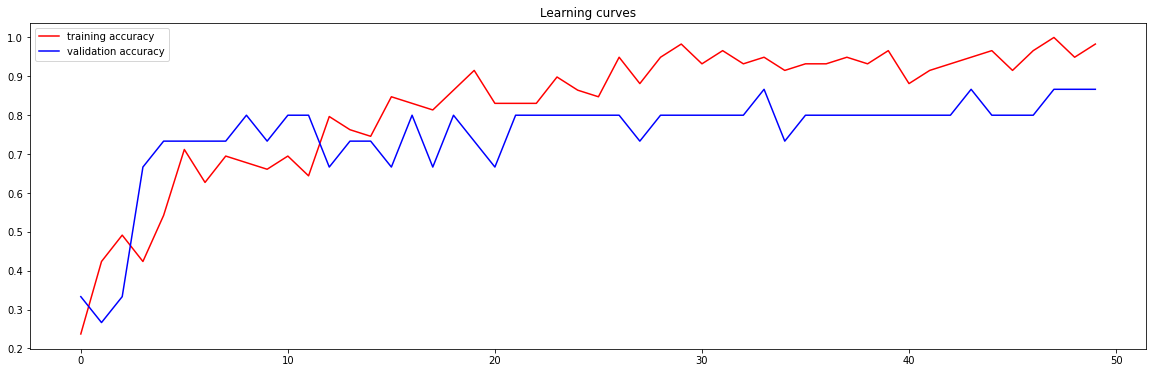

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(20,6))
plt.plot(epochs, acc, 'r', label='training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.title('Learning curves')
plt.legend(loc=0)
plt.show()

### Now we load the model to test its performance on our dataset

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model(os.path.join(path, "car_classification_vgg16_50ep.h5"))

In [ ]:
validation_generator.class_indices

{'BMW': 0, 'Ferrari': 1, 'Lamborghini': 2}

# Function to return the label map

In [ ]:
def label_map(class_indices):
  keys = class_indices.keys()
  values = class_indices.values()
  return dict(zip(values,keys))

### We will iterate through our directories and have our model predict the output

In [ ]:
import numpy as np
from keras.preprocessing import image
import os
 
# Label map
map = label_map(validation_generator.class_indices)

for dir in ['train', 'validation']:
  print()
  print('----------------------------------------------------------')
  print(f'Images in the {dir} set:')
  print()
  for label in map.values():
    print('----------------------------------------------------------')
    print(f'Images of {label}')
    print('{:>35}  {:>10}'.format('file name', 'predicted'))
    print('----------------------------------------------------------')
    # predicting images
    path = os.path.join('data', dir, label)
    list_dir = os.listdir(path)

    for fn in list_dir:
      img = image.load_img(os.path.join(path,fn), target_size=(400, 400))
      x = image.img_to_array(img)
      x /= 255
      x = np.expand_dims(x, axis=0)

      images = np.vstack([x])
      classes = loaded_model.predict(images, batch_size=10)
      predicted = classes.argmax()
      print('{:>35}  {:>10}'.format(fn, map[predicted]))
      

From 15 images in the validation set, 2 were mis classified but the rest were predicted correctly.<br>
Good job!

## Now let's deploy our model using gradio.
### Gradio let's us create a interface for our model. 

In [ ]:
!pip install gradio

In [ ]:
import cv2
import gradio as gr

In [33]:
def car_classifier(image):
    img = cv2.resize(image, (400,400))
    x = tf.convert_to_tensor(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = loaded_model.predict(images, batch_size=10)
    predicted = classes.argmax()
    return map[predicted]

In [34]:
webapp = gr.interface.Interface(fn=car_classifier, inputs=['image'], outputs='label')
webapp.launch(debug=True) # launch the app on local 

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://24872.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f61a8d06710>,
 'http://127.0.0.1:7862/',
 'https://24872.gradio.app')

### You can upload your images and have the model predict it for you.